In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Checking for images and annotations

In [ ]:
import os

base_path = '/content/drive/MyDrive/CARPK_data'
annotations_path = os.path.join(base_path, 'annotations')
images_path = os.path.join(base_path, 'images')
imagesets_path = os.path.join(base_path, 'imagesets')

print("Annotations:", os.listdir(annotations_path)[:5])
print("Images:", os.listdir(images_path)[:5])


Annotations: ['20161029_NTU_00143.txt', '20161225_TPZ_00128.txt', '20161225_TPZ_00007.txt', '20161030_GF2_00099.txt', '20161225_TPZ_00316.txt']
Images: ['20160524_GF2_00094.png', '20161030_GF1_00108.png', '20160524_GF1_00139.png', '20160331_NTU_00033.png', '20160524_GF2_00181.png']


# Heatmap Generation

In [ ]:
import os
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
# Paths
base_path = '/content/drive/MyDrive/CARPK_data'
annotations_path = os.path.join(base_path, 'annotations')
images_path = os.path.join(base_path, 'images')
heatmaps_path = os.path.join(base_path, 'lastheatmap')
os.makedirs(heatmaps_path, exist_ok=True)

target_size = (512, 512)

def generate_heatmap(boxes, shape):
    heatmap = np.zeros(shape, dtype=np.float32)
    for box in boxes:
        x_center = int((box[0] + box[2]) / 2)
        y_center = int((box[1] + box[3]) / 2)
        if 0 <= x_center < shape[1] and 0 <= y_center < shape[0]:
            heatmap[y_center, x_center] += 1
    return gaussian_filter(heatmap, sigma=5)

# Loop through annotation files
for anno_file in tqdm(os.listdir(annotations_path)):
    if not anno_file.endswith('.txt'):
        continue

    image_name = os.path.splitext(anno_file)[0] + '.png'
    image_path = os.path.join(images_path, image_name)
    if not os.path.exists(image_path):
        print(f"Image not found for annotation: {anno_file}")
        continue

    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        continue

    orig_h, orig_w = image.shape[:2]
    scale_x = target_size[0] / orig_w
    scale_y = target_size[1] / orig_h
    image = cv2.resize(image, target_size)

    # Read bounding boxes
    boxes = []
    with open(os.path.join(annotations_path, anno_file), 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                try:
                    x1, y1, x2, y2 = map(int, parts[:4])
                    x1 = int(x1 * scale_x)
                    x2 = int(x2 * scale_x)
                    y1 = int(y1 * scale_y)
                    y2 = int(y2 * scale_y)
                    boxes.append([x1, y1, x2, y2])
                except ValueError:
                    continue

    if not boxes:
        print(f"No valid boxes in {anno_file}")
        continue

    # Generate heatmap
    heatmap = generate_heatmap(boxes, target_size)
    heatmap = (heatmap / heatmap.max()) * 255
    heatmap = heatmap.astype(np.uint8)

    save_path = os.path.join(heatmaps_path, os.path.splitext(anno_file)[0] + '.png')
    cv2.imwrite(save_path, heatmap)


100%|██████████| 1448/1448 [12:01<00:00,  2.01it/s]


# Visualizing random five heatmaps

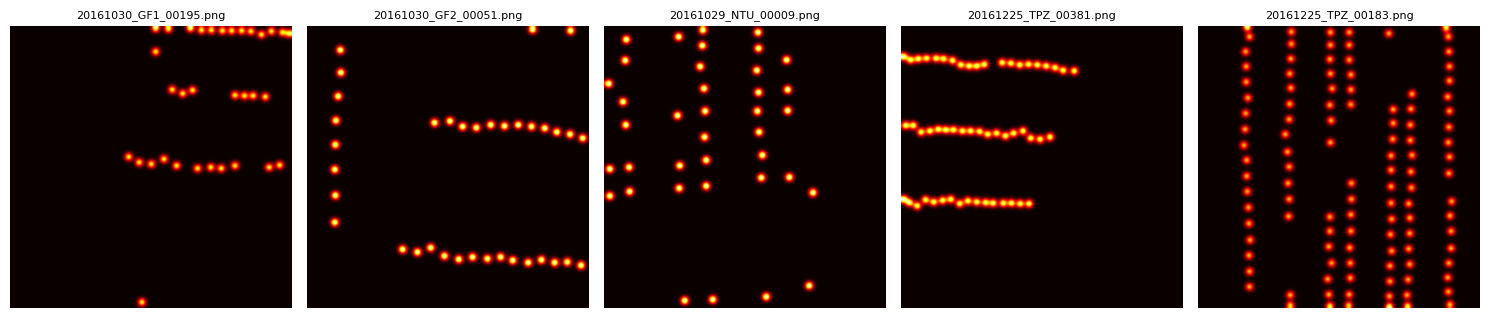

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Define the path to the 'heatmaps' folder in your CARPK dataset
heatmaps_path = '/content/drive/MyDrive/CARPK_data/lastheatmap'  # Update this path if necessary

# List all heatmap files
heatmap_files = os.listdir(heatmaps_path)

# Select 5 random files
random_files = random.sample(heatmap_files, min(5, len(heatmap_files)))

# Create a 1x5 grid (1 row, 5 columns)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))  # Adjust width & height

# Loop through each subplot and add heatmap
for i, ax in enumerate(axes):
    f = random_files[i]
    path = os.path.join(heatmaps_path, f)
    heatmap = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    ax.imshow(heatmap, cmap='hot')
    ax.set_title(f, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os

heatmap_folder = '/content/drive/MyDrive/CARPK_data/lastheatmap'
files = os.listdir(heatmap_folder)
print("Total heatmap files found:", len(files))
print("Some sample files:", files[:5])


Total heatmap files found: 1448
Some sample files: ['20161030_GF2_00076.png', '20161029_NTU_00092.png', '20161029_NTU_00112.png', '20161030_GF2_00147.png', '20160524_GF2_00153.png']


# LCDnet MODEL creation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LCDnet(nn.Module):
    def __init__(self):
        super(LCDnet, self).__init__()

        # Backbone - 6 Conv Layers in 3 Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 1/2
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 1/4
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 1/8
        )

        # Local Context Module (LCM) - Multi-Scale Conv
        self.lcm = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Global Context Module (GCM) - Dilated Convs
        self.gcm = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=4, dilation=4),
            nn.ReLU()
        )

        # Regressor - output density map
        self.regressor = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        local_feat = self.lcm(x)
        global_feat = self.gcm(x)

        combined = torch.cat((local_feat, global_feat), dim=1)
        output = self.regressor(combined)
        return output


# Splitting dataset

In [ ]:
import os
import random
import shutil

# Base paths
base_path = '/content/drive/MyDrive/CARPK_data'
images_dir = os.path.join(base_path, 'images')
heatmaps_dir = os.path.join(base_path, 'lastheatmap')  # adjust to actual heatmap folder

train_img_dir = os.path.join(base_path, 'train/images')
train_heatmap_dir = os.path.join(base_path, 'train/heatmaps')
test_img_dir = os.path.join(base_path, 'test/images')
test_heatmap_dir = os.path.join(base_path, 'test/heatmaps')

# Create directories
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_heatmap_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_heatmap_dir, exist_ok=True)

# Get valid files (present in both folders)
image_files = set(f for f in os.listdir(images_dir) if f.endswith('.png'))
heatmap_files = set(f for f in os.listdir(heatmaps_dir) if f.endswith('.png'))
valid_files = list(image_files & heatmap_files)

# Shuffle and split
random.seed(42)
random.shuffle(valid_files)

total_available = len(valid_files)
train_count = min(989, int(0.7 * total_available))  # fallback in case fewer files
test_count = min(459, total_available - train_count)

train_files = valid_files[:train_count]
test_files = valid_files[train_count:train_count + test_count]

# Copy files function
def copy_files(file_list, src_img_dir, src_heatmap_dir, dst_img_dir, dst_heatmap_dir):
    for fname in file_list:
        shutil.copy(os.path.join(src_img_dir, fname), os.path.join(dst_img_dir, fname))
        shutil.copy(os.path.join(src_heatmap_dir, fname), os.path.join(dst_heatmap_dir, fname))

# Perform copy
copy_files(train_files, images_dir, heatmaps_dir, train_img_dir, train_heatmap_dir)
copy_files(test_files, images_dir, heatmaps_dir, test_img_dir, test_heatmap_dir)

print(f"✅ Splitting Done: {len(train_files)} training images + {len(test_files)} testing images.")


✅ Splitting Done: 989 training images + 459 testing images.


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Dataset class
class CrowdDataset(Dataset):
    def __init__(self, img_dir, heatmap_dir, transform=None):
        self.img_dir = img_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform
        self.filenames = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        heatmap_path = os.path.join(self.heatmap_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
        heatmap = cv2.resize(heatmap, (64, 64))
        heatmap = torch.from_numpy(heatmap).unsqueeze(0).float() / 255.0  # shape: (1, 64, 64)


        if self.transform:
            image = self.transform(image)

        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        # heatmap = torch.from_numpy(heatmap).float()

        return image, heatmap

# Load data
train_dataset = CrowdDataset(
    img_dir='/content/drive/MyDrive/CARPK_data/train/images',
    heatmap_dir='/content/drive/MyDrive/CARPK_data/train/heatmaps'
)
test_dataset = CrowdDataset(
    img_dir='/content/drive/MyDrive/CARPK_data/test/images',
    heatmap_dir='/content/drive/MyDrive/CARPK_data/test/heatmaps'
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model
model = LCDnet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, heatmaps in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        outputs = model(images)
        loss = criterion(outputs, heatmaps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), "lcdnet_carpk.pth")


Epoch 1/20: 100%|██████████| 164/164 [01:26<00:00,  1.89it/s]


Epoch [1/20], Loss: 0.0126


Epoch 2/20: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Epoch [2/20], Loss: 0.0089


Epoch 3/20: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Epoch [3/20], Loss: 0.0066


Epoch 4/20: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Epoch [4/20], Loss: 0.0053


Epoch 5/20: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch [5/20], Loss: 0.0048


Epoch 6/20: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Epoch [6/20], Loss: 0.0045


Epoch 7/20: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Epoch [7/20], Loss: 0.0042


Epoch 8/20: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Epoch [8/20], Loss: 0.0040


Epoch 9/20: 100%|██████████| 164/164 [01:14<00:00,  2.19it/s]


Epoch [9/20], Loss: 0.0037


Epoch 10/20: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch [10/20], Loss: 0.0036


Epoch 11/20: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch [11/20], Loss: 0.0034


Epoch 12/20: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Epoch [12/20], Loss: 0.0032


Epoch 13/20: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch [13/20], Loss: 0.0031


Epoch 14/20: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch [14/20], Loss: 0.0030


Epoch 15/20: 100%|██████████| 164/164 [01:14<00:00,  2.19it/s]


Epoch [15/20], Loss: 0.0029


Epoch 16/20: 100%|██████████| 164/164 [01:14<00:00,  2.19it/s]


Epoch [16/20], Loss: 0.0029


Epoch 17/20: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Epoch [17/20], Loss: 0.0028


Epoch 18/20: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch [18/20], Loss: 0.0027


Epoch 19/20: 100%|██████████| 164/164 [01:15<00:00,  2.19it/s]


Epoch [19/20], Loss: 0.0026


Epoch 20/20: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]

Epoch [20/20], Loss: 0.0025


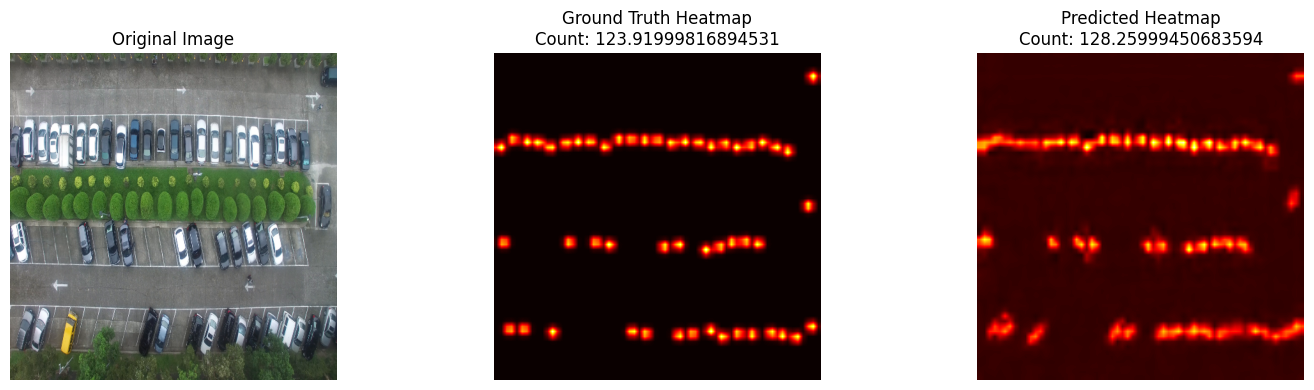

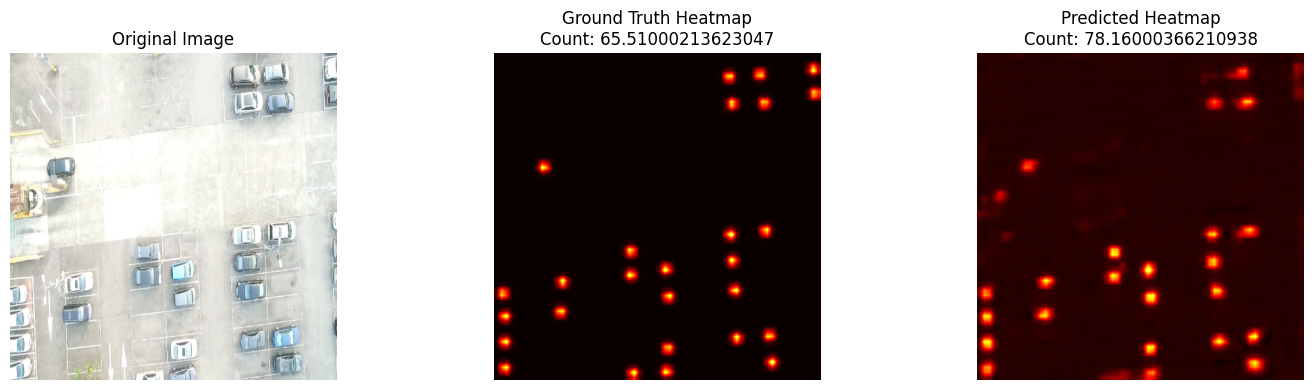

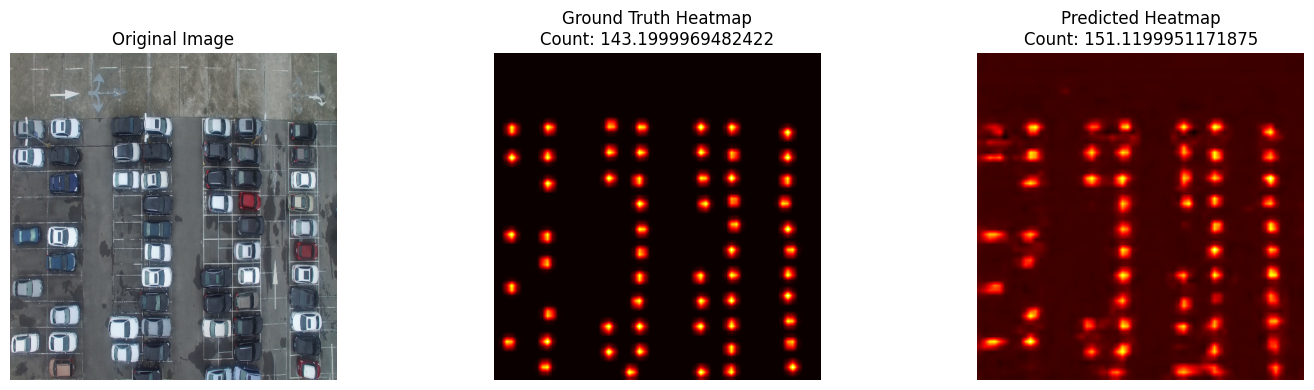

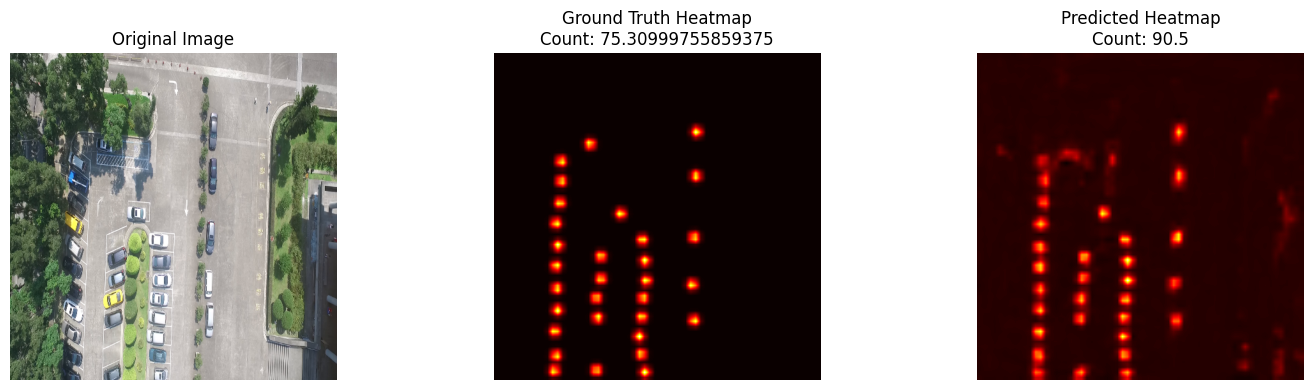

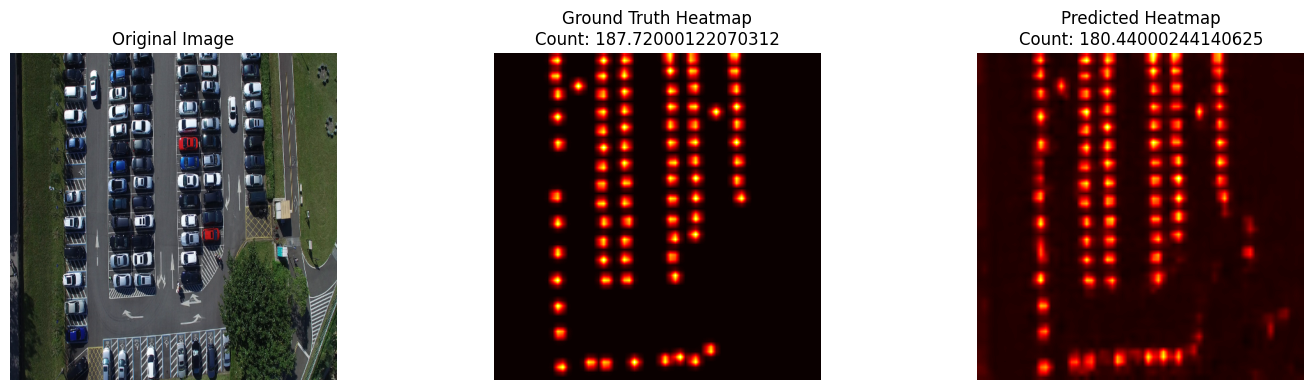

In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for i, (image, gt_heatmap) in enumerate(test_loader):
        image = image.to(device)
        gt_heatmap = gt_heatmap.to(device)

        pred_heatmap = model(image)

        # Get first item from batch
        img_np = image[0].cpu().permute(1, 2, 0).numpy()
        gt_map = gt_heatmap[0][0].cpu().numpy()
        pred_map = pred_heatmap[0][0].cpu().numpy()

        # Count is the sum of heatmap values
        gt_count = round(gt_map.sum(), 2)
        pred_count = round(pred_map.sum(), 2)

        # Plotting
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title(f"Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_map, cmap='hot', interpolation='bilinear')
        plt.title(f"Ground Truth Heatmap\nCount: {gt_count}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_map, cmap='hot', interpolation='bilinear')
        plt.title(f"Predicted Heatmap\nCount: {pred_count}")
        plt.axis("off")


        plt.tight_layout()
        plt.show()

        # Limit to first 5 samples
        if i == 4:
            break


In [ ]:
train_losses = []
test_losses = []
train_counts = []
test_counts = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    for images, heatmaps in train_loader:
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        outputs = model(images)
        loss = criterion(outputs, heatmaps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Count prediction
        pred_count = outputs.detach().sum(dim=(1, 2, 3)).cpu()
        true_count = heatmaps.sum(dim=(1, 2, 3)).cpu()
        train_mae += torch.abs(pred_count - true_count).mean().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mae = train_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    train_counts.append(avg_train_mae)

    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    test_mae = 0.0
    with torch.no_grad():
        for images, heatmaps in test_loader:
            images = images.to(device)
            heatmaps = heatmaps.to(device)

            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            test_loss += loss.item()

            pred_count = outputs.sum(dim=(1, 2, 3)).cpu()
            true_count = heatmaps.sum(dim=(1, 2, 3)).cpu()
            test_mae += torch.abs(pred_count - true_count).mean().item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_mae = test_mae / len(test_loader)
    test_losses.append(avg_test_loss)
    test_counts.append(avg_test_mae)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f}, MAE: {avg_train_mae:.2f} | Test Loss: {avg_test_loss:.4f}, MAE: {avg_test_mae:.2f}")


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
print("Number of train images:", len(train_dataset))
print("Some sample filenames:", train_dataset.filenames[:5])


Number of train images: 1308
Some sample filenames: ['20161029_NTU_00062.png', '20161030_GF2_00060.png', '20161225_TPZ_00282.png', '20161030_GF2_00101.png', '20161029_NTU_00124.png']


In [ ]:
import os
heatmap_dir = '/content/drive/MyDrive/CARPK_data/train/heatmaps'
heatmap_filenames = [f for f in os.listdir(heatmap_dir) if f.endswith('.png')]
print("Number of heatmap images:", len(heatmap_filenames))
print("Some heatmap filenames:", heatmap_filenames[:5])


Number of heatmap images: 1308
Some heatmap filenames: ['20161029_NTU_00062.png', '20161030_GF2_00060.png', '20161225_TPZ_00282.png', '20161030_GF2_00101.png', '20161029_NTU_00124.png']


In [ ]:
def __getitem__(self, idx):
    img_name = self.filenames[idx]
    img_path = os.path.join(self.img_dir, img_name)
    heatmap_path = os.path.join(self.heatmap_dir, img_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"Warning: Image not loaded properly: {img_path}")
    image = cv2.resize(image, (512, 512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    if heatmap is None:
        print(f"Warning: Heatmap not loaded properly: {heatmap_path}")
    heatmap = cv2.resize(heatmap, (64, 64))
    heatmap = torch.from_numpy(heatmap).unsqueeze(0).float() / 255.0  # shape: (1, 64, 64)

    if self.transform:
        image = self.transform(image)

    image = torch.from_numpy(image.transpose((2, 0, 1))).float()

    return image, heatmap


In [ ]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load("lcdnet_carpk.pth"))
model.eval()

test_loss = 0.0
test_mae = 0.0
with torch.no_grad():
    for images, heatmaps in test_loader:
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        test_loss += loss.item()

        pred_count = outputs.sum(dim=(1, 2, 3)).cpu()
        true_count = heatmaps.sum(dim=(1, 2, 3)).cpu()
        test_mae += torch.abs(pred_count - true_count).mean().item()

avg_test_loss = test_loss / len(test_loader)
avg_test_mae = test_mae / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.2f}")


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Dataset class with mismatch handling
class CrowdDataset(Dataset):
    def __init__(self, img_dir, heatmap_dir, transform=None):
        self.img_dir = img_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform

        # Find common files in both folders to avoid mismatch
        img_files = set(f for f in os.listdir(img_dir) if f.endswith('.png'))
        heatmap_files = set(f for f in os.listdir(heatmap_dir) if f.endswith('.png'))
        self.filenames = sorted(list(img_files.intersection(heatmap_files)))

        print(f"Number of matched images: {len(self.filenames)}")
        if len(self.filenames) == 0:
            raise RuntimeError("No matching images and heatmaps found!")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        heatmap_path = os.path.join(self.heatmap_dir, img_name)

        image = cv2.imread(img_path)
        heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)

        if image is None or heatmap is None:
            raise RuntimeError(f"Failed to load image or heatmap for {img_name}")

        # Resize images safely
        image = cv2.resize(image, (512, 512))
        heatmap = cv2.resize(heatmap, (64, 64))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if self.transform:
            image = self.transform(image)

        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        heatmap = torch.from_numpy(heatmap).unsqueeze(0).float() / 255.0

        return image, heatmap

# Initialize datasets and loaders
train_dataset = CrowdDataset(
    img_dir='/content/drive/MyDrive/CARPK_data/train/images',
    heatmap_dir='/content/drive/MyDrive/CARPK_data/train/heatmaps'
)
test_dataset = CrowdDataset(
    img_dir='/content/drive/MyDrive/CARPK_data/test/images',
    heatmap_dir='/content/drive/MyDrive/CARPK_data/test/heatmaps'
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Your model definition here (replace LCDnet with your actual model class)
model = LCDnet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

train_losses = []
test_losses = []
train_mae = []
test_mae = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_mae = 0.0

    for images, heatmaps in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Counting cars (sum over heatmap pixels)
        pred_count = outputs.detach().sum(dim=(1, 2, 3)).cpu()
        true_count = heatmaps.sum(dim=(1, 2, 3)).cpu()
        running_train_mae += torch.abs(pred_count - true_count).mean().item()

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_mae = running_train_mae / len(train_loader)

    model.eval()
    running_test_loss = 0.0
    running_test_mae = 0.0

    with torch.no_grad():
        for images, heatmaps in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            heatmaps = heatmaps.to(device)

            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            running_test_loss += loss.item()

            pred_count = outputs.sum(dim=(1, 2, 3)).cpu()
            true_count = heatmaps.sum(dim=(1, 2, 3)).cpu()
            running_test_mae += torch.abs(pred_count - true_count).mean().item()

    avg_test_loss = running_test_loss / len(test_loader)
    avg_test_mae = running_test_mae / len(test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_mae.append(avg_train_mae)
    test_mae.append(avg_test_mae)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.2f} | Test Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.2f}")


Number of matched images: 1308
Number of matched images: 497


Evaluating: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch [1/20] - Train Loss: 0.0109, Train MAE: 46.35 | Test Loss: 0.0089, Test MAE: 25.34


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch [2/20] - Train Loss: 0.0078, Train MAE: 30.96 | Test Loss: 0.0070, Test MAE: 21.38


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch [3/20] - Train Loss: 0.0063, Train MAE: 27.78 | Test Loss: 0.0058, Test MAE: 26.34


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.42it/s]


Epoch [4/20] - Train Loss: 0.0054, Train MAE: 29.63 | Test Loss: 0.0050, Test MAE: 20.39


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch [5/20] - Train Loss: 0.0049, Train MAE: 30.29 | Test Loss: 0.0046, Test MAE: 20.46


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch [6/20] - Train Loss: 0.0045, Train MAE: 24.43 | Test Loss: 0.0044, Test MAE: 33.68


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch [7/20] - Train Loss: 0.0042, Train MAE: 26.61 | Test Loss: 0.0040, Test MAE: 17.08


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch [8/20] - Train Loss: 0.0040, Train MAE: 28.15 | Test Loss: 0.0040, Test MAE: 31.62


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch [9/20] - Train Loss: 0.0038, Train MAE: 24.94 | Test Loss: 0.0036, Test MAE: 18.49


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch [10/20] - Train Loss: 0.0036, Train MAE: 22.84 | Test Loss: 0.0036, Test MAE: 27.24


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch [11/20] - Train Loss: 0.0034, Train MAE: 23.43 | Test Loss: 0.0033, Test MAE: 28.69


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch [12/20] - Train Loss: 0.0032, Train MAE: 20.90 | Test Loss: 0.0032, Test MAE: 32.46


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch [13/20] - Train Loss: 0.0031, Train MAE: 21.82 | Test Loss: 0.0031, Test MAE: 21.25


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch [14/20] - Train Loss: 0.0030, Train MAE: 24.68 | Test Loss: 0.0030, Test MAE: 32.03


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch [15/20] - Train Loss: 0.0029, Train MAE: 23.46 | Test Loss: 0.0028, Test MAE: 18.95


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch [16/20] - Train Loss: 0.0028, Train MAE: 21.92 | Test Loss: 0.0027, Test MAE: 23.47


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch [17/20] - Train Loss: 0.0027, Train MAE: 21.25 | Test Loss: 0.0026, Test MAE: 19.16


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch [18/20] - Train Loss: 0.0026, Train MAE: 19.00 | Test Loss: 0.0025, Test MAE: 15.43


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch [19/20] - Train Loss: 0.0026, Train MAE: 22.89 | Test Loss: 0.0025, Test MAE: 18.71


Evaluating: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]

Epoch [20/20] - Train Loss: 0.0025, Train MAE: 21.82 | Test Loss: 0.0026, Test MAE: 29.99


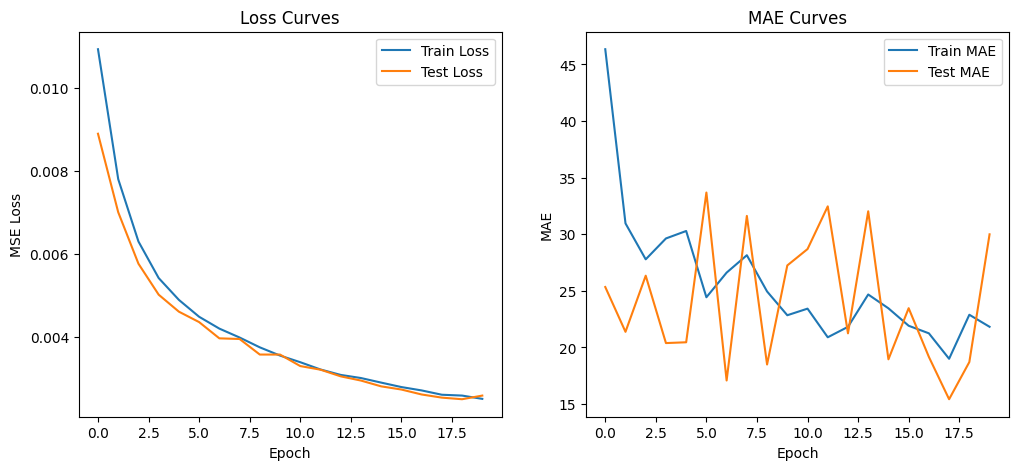

In [ ]:
# After training, plot losses and MAE
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_mae, label='Train MAE')
plt.plot(test_mae, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Curves')
plt.legend()

plt.show()

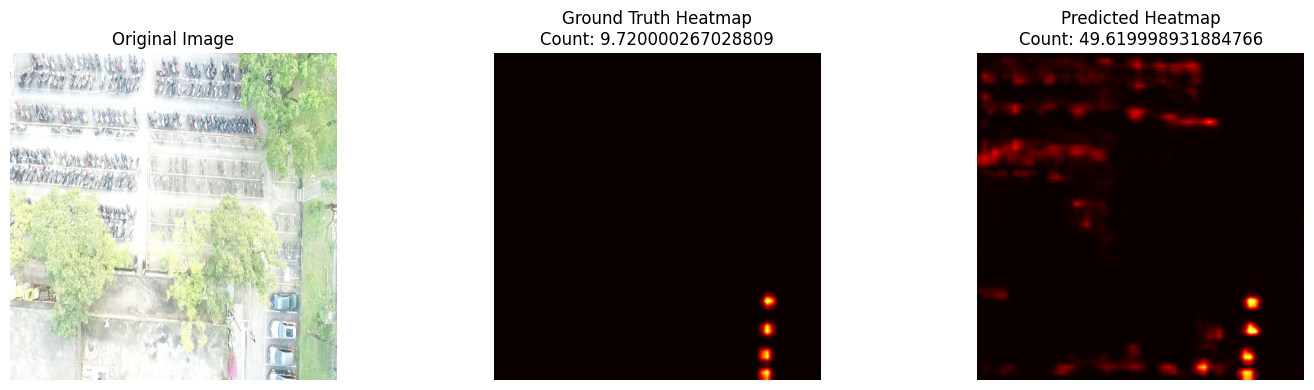

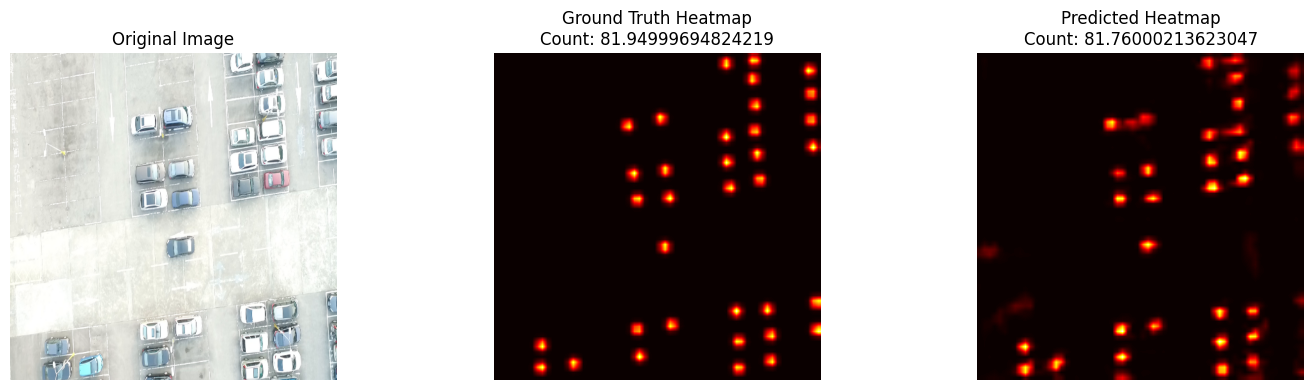

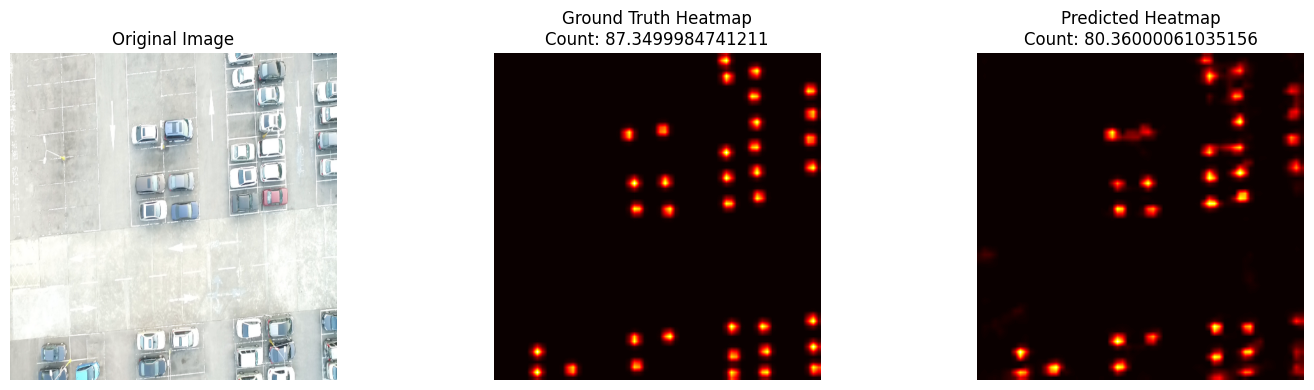

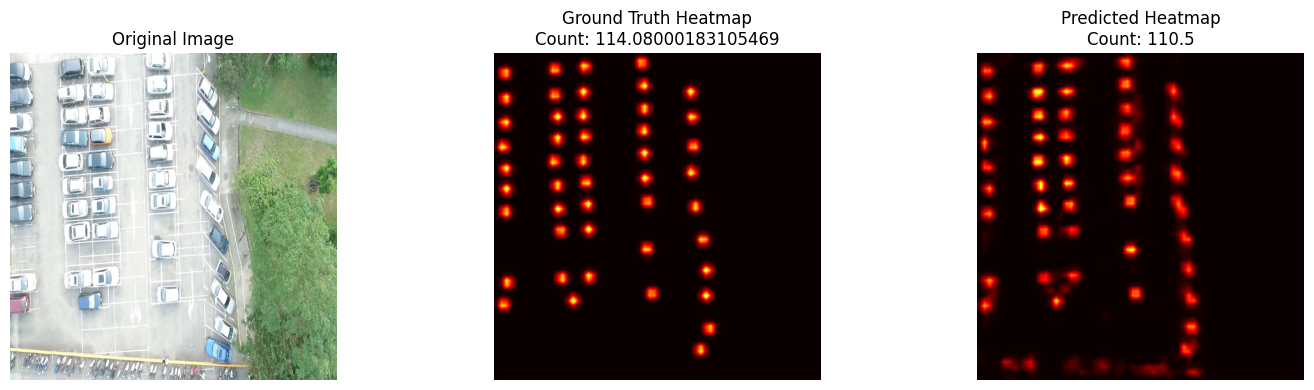

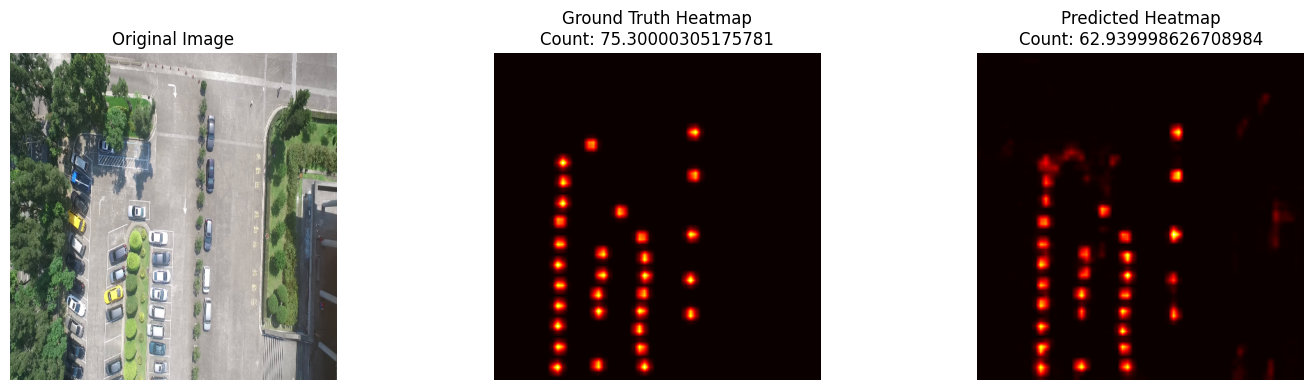

In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for i, (image, gt_heatmap) in enumerate(test_loader):
        image = image.to(device)
        gt_heatmap = gt_heatmap.to(device)

        pred_heatmap = model(image)

        # Extract first item from batch
        img_np = image[0].cpu().permute(1, 2, 0).numpy()
        gt_map = gt_heatmap[0, 0].cpu().numpy()
        pred_map = pred_heatmap[0, 0].cpu().numpy()

        # Denormalize if you normalized image before (optional)
        # img_np = (img_np * std + mean) if any transform applied

        # Clamp heatmaps to [0, 1] range if needed (for display)
        gt_map = np.clip(gt_map, 0, 1)
        pred_map = np.clip(pred_map, 0, 1)

        # Compute counts
        gt_count = round(gt_map.sum(), 2)
        pred_count = round(pred_map.sum(), 2)

        # Plotting
        plt.figure(figsize=(15, 4))


        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title(f"Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_map, cmap='hot',interpolation= 'bilinear')
        plt.title(f"Ground Truth Heatmap\nCount: {gt_count}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_map, cmap='hot',interpolation='bilinear')
        plt.title(f"Predicted Heatmap\nCount: {pred_count}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        if i == 4:
            break  # Show only first 5 samples


In [ ]:
import torch
import numpy as np

model.eval()
mae = 0.0
mse = 0.0
correct = 0.0
total_samples = 0

with torch.no_grad():
    for images, heatmaps in test_loader:
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        outputs = model(images)

        # Predicted and true counts
        pred_count = outputs.sum(dim=(1, 2, 3)).cpu().numpy()
        true_count = heatmaps.sum(dim=(1, 2, 3)).cpu().numpy()

        mae += np.abs(pred_count - true_count).sum()
        mse += ((pred_count - true_count) ** 2).sum()
        total_samples += images.size(0)

# Final metrics
mae /= total_samples
rmse = np.sqrt(mse / total_samples)
accuracy = (correct / total_samples) * 100
print(f"\n🔍 Final Accuracy on Test Set:")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"Accuracy within ±10% tolerance: {accuracy:.2f}%")


🔍 Final Accuracy on Test Set:
MAE  (Mean Absolute Error): 30.22
RMSE (Root Mean Squared Error): 35.86
Accuracy within ±10% tolerance: 0.00%


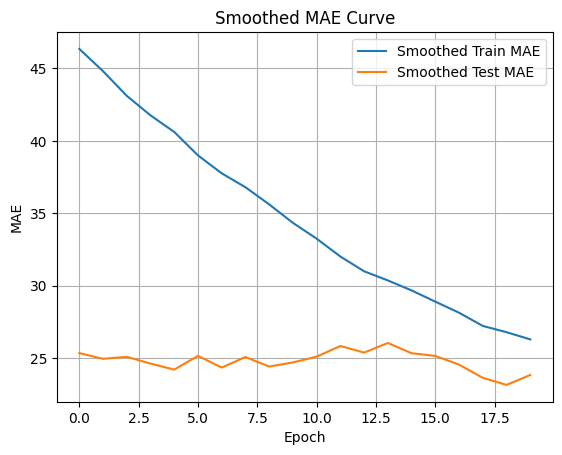

In [ ]:
def smooth_curve(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

plt.plot(smooth_curve(train_mae), label='Smoothed Train MAE')
plt.plot(smooth_curve(test_mae), label='Smoothed Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Smoothed MAE Curve')
plt.grid(True)
plt.show()


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ------------------ Dataset Class ------------------
class CrowdDataset(Dataset):
    def __init__(self, img_dir, heatmap_dir, transform=None):
        self.img_dir = img_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform

        img_files = set(f for f in os.listdir(img_dir) if f.endswith('.png'))
        heatmap_files = set(f for f in os.listdir(heatmap_dir) if f.endswith('.png'))
        self.filenames = sorted(list(img_files.intersection(heatmap_files)))

        print(f"Number of matched images: {len(self.filenames)}")
        if len(self.filenames) == 0:
            raise RuntimeError("No matching images and heatmaps found!")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        heatmap_path = os.path.join(self.heatmap_dir, img_name)

        image = cv2.imread(img_path)
        heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)

        if image is None or heatmap is None:
            raise RuntimeError(f"Failed to load image or heatmap for {img_name}")

        # Resize (optional: reduce to 256x256 if needed)
        image = cv2.resize(image, (512, 512))
        heatmap = cv2.resize(heatmap, (64, 64))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if self.transform:
            image = self.transform(image)

        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        heatmap = torch.from_numpy(heatmap).unsqueeze(0).float() / 255.0

        return image, heatmap

# ------------------ Setup ------------------
# Replace LCDnet() with your actual model class
model = LCDnet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

model = model.to(device)

# ------------------ Data Loaders ------------------
train_dataset = CrowdDataset(
    img_dir='/content/drive/MyDrive/CARPK_data/train/images',
    heatmap_dir='/content/drive/MyDrive/CARPK_data/train/heatmaps'
)

test_dataset = CrowdDataset(
    img_dir='/content/drive/MyDrive/CARPK_data/test/images',
    heatmap_dir='/content/drive/MyDrive/CARPK_data/test/heatmaps'
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# ------------------ Training Setup ------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20

train_losses, test_losses = [], []
train_mae, test_mae = [], []

# ------------------ Training Loop ------------------
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_mae = 0.0

    for images, heatmaps in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device, non_blocking=True)
        heatmaps = heatmaps.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        pred_count = outputs.sum(dim=(1, 2, 3))
        true_count = heatmaps.sum(dim=(1, 2, 3))
        batch_mae = torch.abs(pred_count - true_count).mean()
        running_train_mae += batch_mae.item()

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_mae = running_train_mae / len(train_loader)

    model.eval()
    running_test_loss = 0.0
    running_test_mae = 0.0

    with torch.no_grad():
        for images, heatmaps in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device, non_blocking=True)
            heatmaps = heatmaps.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            running_test_loss += loss.item()

            pred_count = outputs.sum(dim=(1, 2, 3))
            true_count = heatmaps.sum(dim=(1, 2, 3))
            batch_mae = torch.abs(pred_count - true_count).mean()
            running_test_mae += batch_mae.item()

    avg_test_loss = running_test_loss / len(test_loader)
    avg_test_mae = running_test_mae / len(test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_mae.append(avg_train_mae)
    test_mae.append(avg_test_mae)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, MAE: {avg_train_mae:.2f} | "
          f"Test Loss: {avg_test_loss:.4f}, MAE: {avg_test_mae:.2f}")


Using device: cuda
GPU: Tesla T4
Number of matched images: 1308
Number of matched images: 497


Evaluating: 100%|██████████| 63/63 [04:09<00:00,  3.96s/it]


Epoch [1/20] - Train Loss: 0.0141, MAE: 140.15 | Test Loss: 0.0102, MAE: 39.94


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


Epoch [2/20] - Train Loss: 0.0092, MAE: 36.19 | Test Loss: 0.0085, MAE: 24.84


Evaluating: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]


Epoch [3/20] - Train Loss: 0.0077, MAE: 32.88 | Test Loss: 0.0069, MAE: 22.95


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch [4/20] - Train Loss: 0.0064, MAE: 31.29 | Test Loss: 0.0058, MAE: 22.31


Evaluating: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]


Epoch [5/20] - Train Loss: 0.0056, MAE: 30.11 | Test Loss: 0.0057, MAE: 54.60


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


Epoch [6/20] - Train Loss: 0.0052, MAE: 27.45 | Test Loss: 0.0050, MAE: 37.44


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


Epoch [7/20] - Train Loss: 0.0049, MAE: 30.12 | Test Loss: 0.0046, MAE: 18.76


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


Epoch [8/20] - Train Loss: 0.0045, MAE: 24.82 | Test Loss: 0.0043, MAE: 24.78


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


Epoch [9/20] - Train Loss: 0.0043, MAE: 26.32 | Test Loss: 0.0040, MAE: 21.00


Evaluating: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch [10/20] - Train Loss: 0.0040, MAE: 26.24 | Test Loss: 0.0038, MAE: 16.71


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Epoch [11/20] - Train Loss: 0.0038, MAE: 24.47 | Test Loss: 0.0036, MAE: 19.52


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


Epoch [12/20] - Train Loss: 0.0036, MAE: 23.74 | Test Loss: 0.0035, MAE: 16.86


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Epoch [13/20] - Train Loss: 0.0035, MAE: 21.68 | Test Loss: 0.0034, MAE: 25.29


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


Epoch [14/20] - Train Loss: 0.0033, MAE: 23.47 | Test Loss: 0.0032, MAE: 17.50


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


Epoch [15/20] - Train Loss: 0.0033, MAE: 27.10 | Test Loss: 0.0032, MAE: 33.97


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Epoch [16/20] - Train Loss: 0.0031, MAE: 20.83 | Test Loss: 0.0031, MAE: 20.54


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


Epoch [17/20] - Train Loss: 0.0031, MAE: 24.48 | Test Loss: 0.0030, MAE: 29.18


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]


Epoch [18/20] - Train Loss: 0.0029, MAE: 21.70 | Test Loss: 0.0029, MAE: 26.40


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


Epoch [19/20] - Train Loss: 0.0028, MAE: 19.75 | Test Loss: 0.0028, MAE: 19.02


Evaluating: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]

Epoch [20/20] - Train Loss: 0.0028, MAE: 20.69 | Test Loss: 0.0027, MAE: 15.45


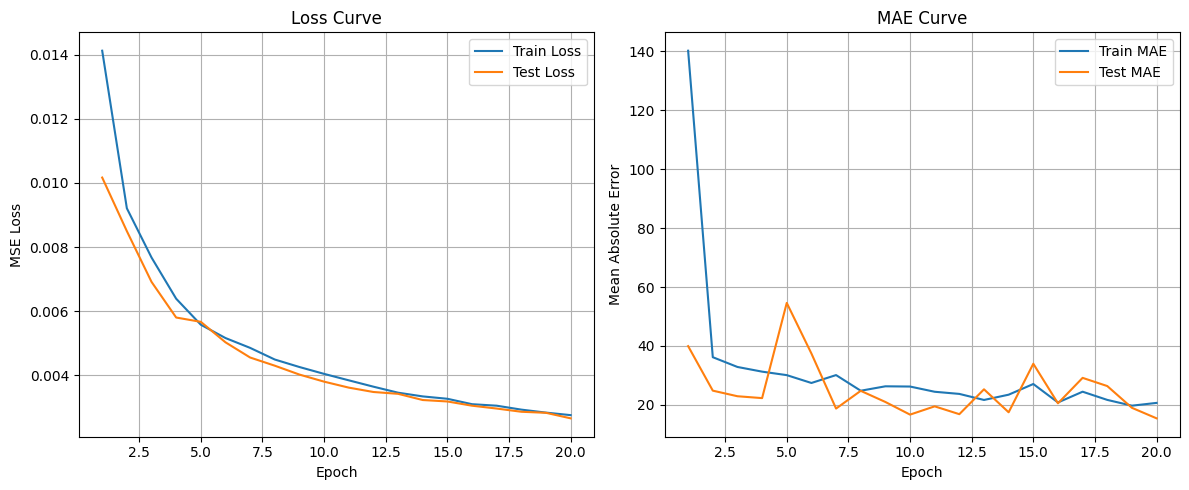

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss' )
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Train MAE')
plt.plot(epochs_range, test_mae, label='Test MAE')
plt.title('MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Prediction on images

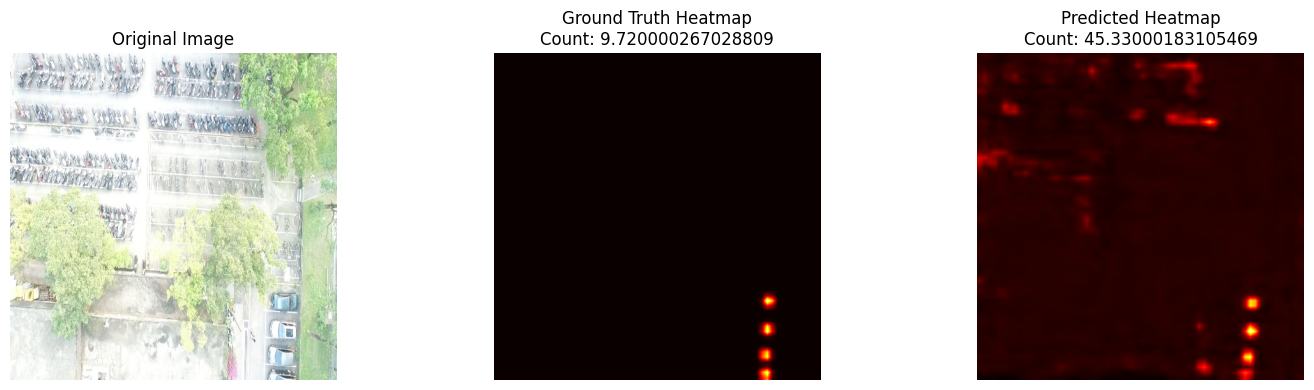

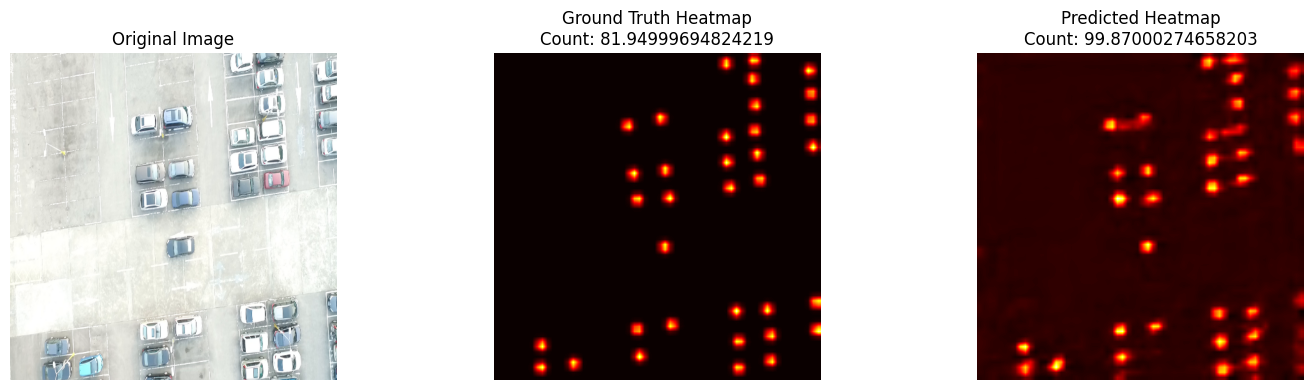

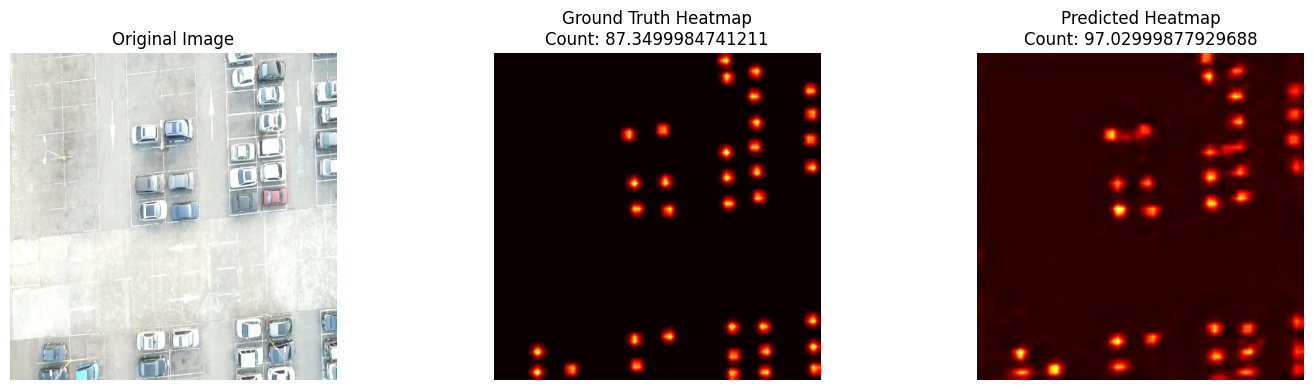

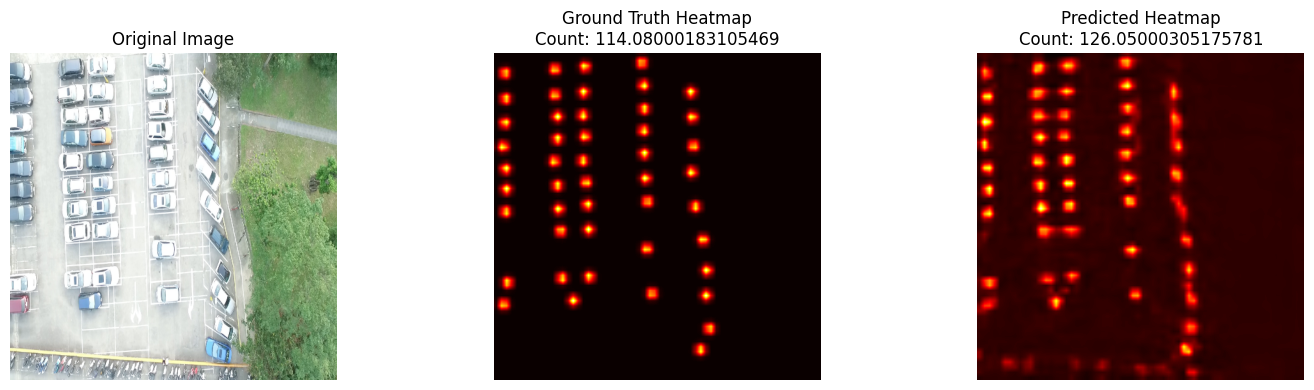

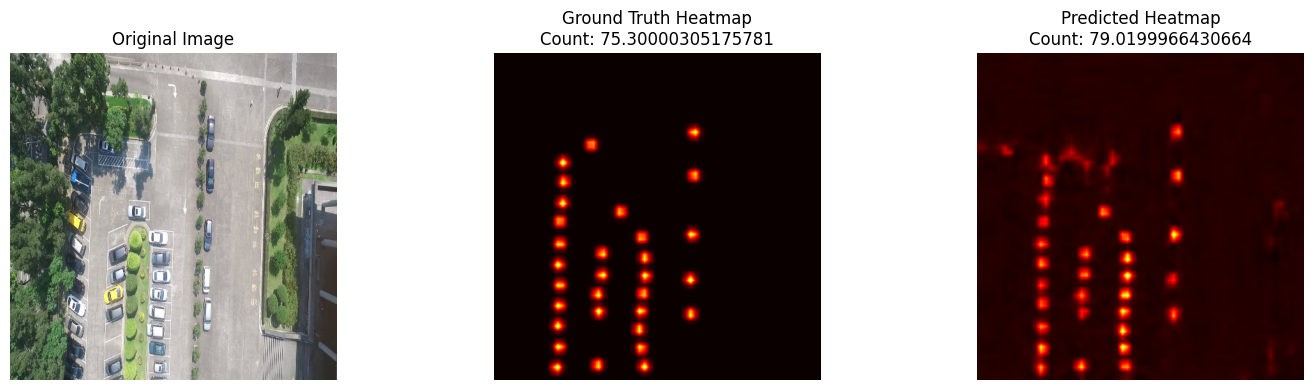

In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for i, (image, gt_heatmap) in enumerate(test_loader):
        image = image.to(device)
        gt_heatmap = gt_heatmap.to(device)

        pred_heatmap = model(image)

        # Get the first item from the batch
        img_np = image[0].cpu().permute(1, 2, 0).numpy()
        gt_map = gt_heatmap[0][0].cpu().numpy()
        pred_map = pred_heatmap[0][0].cpu().numpy()

        # Sum of heatmap values = count
        gt_count = round(gt_map.sum(), 2)
        pred_count = round(pred_map.sum(), 2)

        # Plot
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_map, cmap='hot', interpolation='bilinear')
        plt.title(f"Ground Truth Heatmap\nCount: {gt_count}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_map, cmap='hot', interpolation='bilinear')
        plt.title(f"Predicted Heatmap\nCount: {pred_count}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        if i == 4:  # Show first 5 samples only
            break


# Prediction on some unseen images

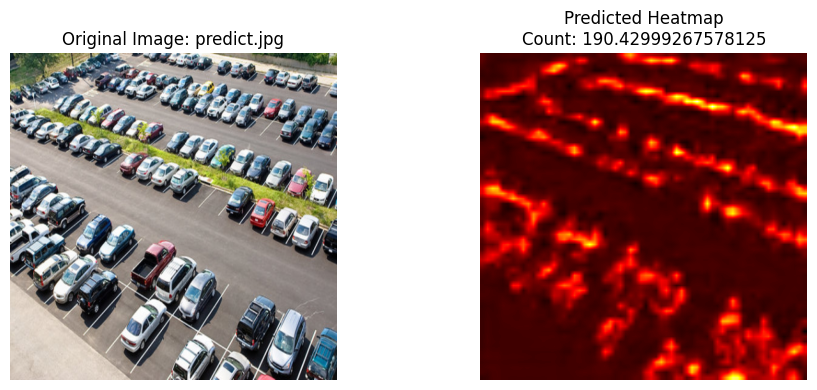

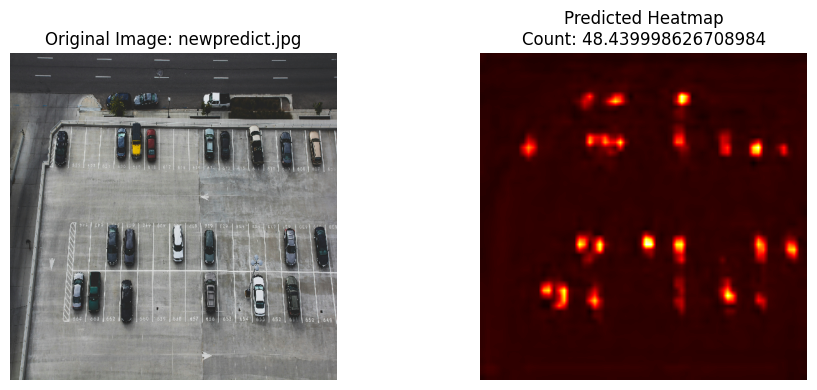

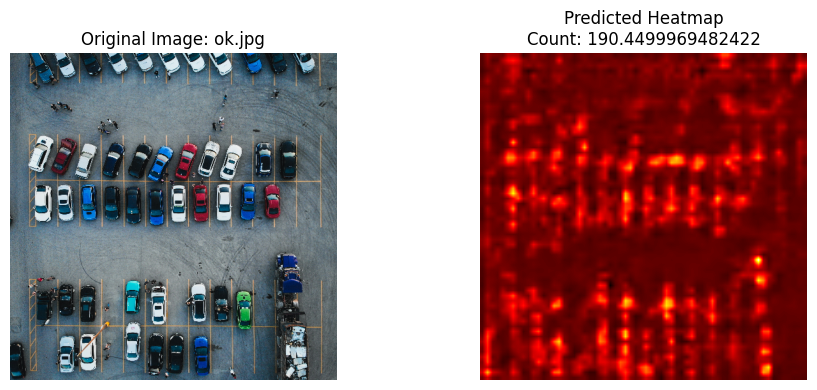

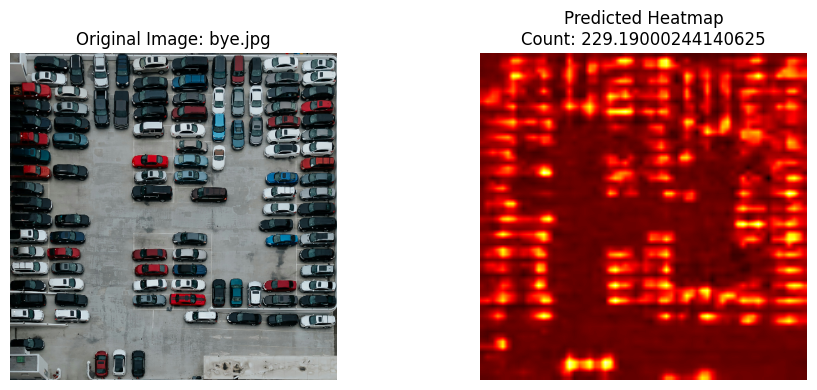

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set folder path and device
unseen_folder = '/content/drive/MyDrive/CARPK_data/test_images'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Prediction loop for unseen images
with torch.no_grad():
    for filename in os.listdir(unseen_folder):
        if not filename.endswith('.jpg'):
            continue

        img_path = os.path.join(unseen_folder, filename)

        # Load and preprocess image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not load {filename}")
            continue

        image = cv2.resize(image, (512, 512))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image_rgb.transpose((2, 0, 1))).unsqueeze(0).float().to(device)

        # Predict heatmap
        pred_heatmap = model(image_tensor)
        pred_map = pred_heatmap[0][0].cpu().numpy()
        pred_count = round(pred_map.sum(), 2)

        # Visualization
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(image_rgb)
        plt.title(f"Original Image: {filename}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_map, cmap='hot', interpolation='bilinear')
        plt.title(f"Predicted Heatmap\nCount: {pred_count}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
# Save model after training
save_path = '/content/drive/MyDrive/CARPK_data/trained_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/CARPK_data/trained_model.pth


In [ ]:
import os

model_dir = '/content/drive/MyDrive/CARPK_data'
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
print("Available model files:", model_files)


Available model files: ['trained_model.pth']


In [ ]:
model.summary()

NameError: name 'model' is not defined

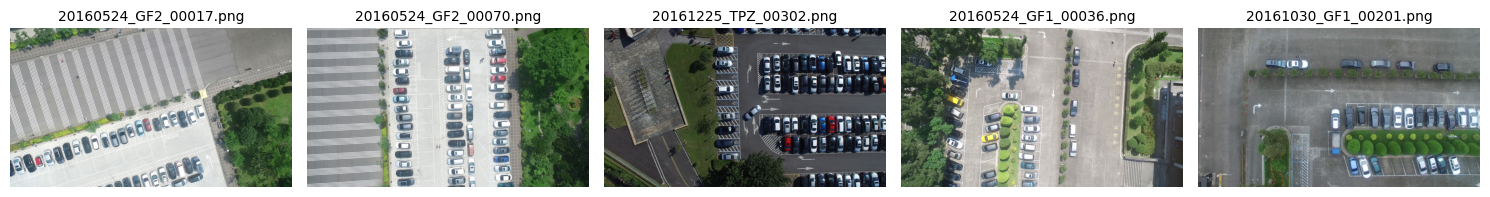

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Change this to either train or test folder
image_folder = '/content/drive/MyDrive/CARPK_data/images'

# List all image files
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

# Randomly select 5
sample_images = random.sample(image_files, 5)

# Plot the images
plt.figure(figsize=(15, 6))
for i, img_file in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_file)
    image = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{img_file}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
pip install torchsummary


In [ ]:
from torchsummary import summary
import torch

# Make sure your model is defined
model = LCDnet().cuda()  # Use .cpu() if not using GPU

# Input shape = (channels, height, width) = (3, 128, 128) for CARPK dataset
summary(model, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
         MaxPool2d-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
        MaxPool2d-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
             ReLU-14           [-1, 64,